# [DACON] 생육 환경 최적화 경진대회
[참고 | CNN+CatBoost+ANN](https://dacon.io/competitions/official/235897/codeshare/5017?page=1&dtype=recent)  
- DL과 ML을 섞어 사용했다는 점이 흥미로웠음

### Abstraction
- CNN: 이미지 밝기 조절 -> 마스킹(HSV) -> 픽셀 비율 추출 -> 이상치 처리 -> 학습
- CatBoost, ANN : 이미지 픽셀 비율 Feature 변수로 포함 -> 전처리 -> 학습

### Library

In [ ]:
import os
from glob import glob

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import groupby
import random

import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import koreanize_matplotlib

In [4]:
main_path = "./open"
train_imgs = glob(main_path + "/train/*/*/*.png") + glob(main_path + "/train/*/*/*.jpg")
train_imgs = sorted(train_imgs)
test_imgs = glob(main_path + "/test/image/*.png") + glob(main_path + "/test/image/*.jpg")
test_imgs = sorted(test_imgs)
train_data = glob(main_path + "/train/*/meta/*.csv")
train_data = sorted(train_data)
train_label = glob(main_path + "/train/*/*.csv")
train_label = sorted(train_label)
test_data = glob(main_path + "/test/meta/*.csv")
test_data = sorted(test_data)

preprocessing_train_imgs = main_path + "/PREPROCESSING-TRAIN"
preprocessing_test_imgs = main_path + "/PREPROCESSING-TEST"

if not os.path.exists(preprocessing_train_imgs):
    os.mkdir(preprocessing_train_imgs)
if not os.path.exists(preprocessing_test_imgs):
    os.mkdir(preprocessing_test_imgs)

### Image Augmentation
Grayscale 히스토그램을 이용해 모든 이미지 밝기 자동 조절

In [5]:
def automatic_brightness_and_contrast(img, clip_hist_pct=0.025):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate grayscale hist
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_size = len(hist)
    # Calculate cumulative distribution from the hist
    accumulator = []
    accumulator.append(float(hist[0]))
    for idx in range(1, hist_size):
        accumulator.append(accumulator[idx-1]+float(hist[idx]))
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_pct *= (maximum/100.0)
    clip_hist_pct /= 2.0
    # Locate Left Cut
    minimum_gray = 0
    while accumulator[minimum_gray]<clip_hist_pct: minimum_gray += 1
    # Locate Right Cut
    maximum_gray = hist_size-1
    while accumulator[maximum_gray]>=(maximum-clip_hist_pct): maximum_gray -= 1
    # Calculate alpha and beta val.
    alpha = 255 / (maximum_gray-minimum_gray)
    beta = -minimum_gray*alpha

    auto_result = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return (auto_result)

### Data Processing
- 이미지 밝기 조절 후 HSV를 이용해 특정 색상 오브젝트 추출
- 마스킹 된 이미지 픽셀 비율 값 추출 (W / W + B)

In [6]:
def get_image_data(dir_in, dir_out):
    ratio_list = []
    for i in tqdm(dir_in):
        name = i.split("\\")[-1]
        img = cv2.imread(i, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (615, 462))
        brightscale = automatic_brightness_and_contrast(img)
        imgcopy = brightscale.copy()
        hsvimg = cv2.cvtColor(brightscale, cv2.COLOR_BGR2HSV)
        lower = np.array([22, 40, 0])
        upper = np.array([85, 255, 245])
        mask = cv2.inRange(hsvimg, lower, upper)
        number_of_white_pix = np.sum(mask==255)
        number_of_black_pix = np.sum(mask==0)
        ratio = number_of_white_pix / (number_of_white_pix + number_of_black_pix)
        ratio_list.append(ratio)
        result = cv2.bitwise_and(imgcopy, imgcopy, mask=mask)
        cv2.imwrite(os.path.join(dir_out, name), result)
    return ratio_list

In [7]:
ratio_train = get_image_data(train_imgs, preprocessing_train_imgs)
ratio_test = get_image_data(test_imgs, preprocessing_test_imgs)

processed_train_imgs = glob(main_path+"/PREPROCESSING-TRAIN/*.png") + glob(main_path+"/PREPROCESSING-TRAIN/*.jpg")
processed_train_imgs = sorted(processed_train_imgs)

processed_test_imgs = glob(main_path+"/PREPROCESSING-TEST/*.png") + glob(main_path+"/PREPROCESSING-TEST/*.jpg")
processed_test_imgs = sorted(processed_test_imgs)

100%|██████████| 460/460 [01:24<00:00,  5.44it/s]


- 정량이 정해져 있는 변수는 `bfill, ffill`로 결측값 대체 (최근 분무량)
- 정량이 정해져 있지 않은 변수는 보간법 이용
- 최근 분무량 데이터는, 일간 누적 분무량으로 측정이 되어 모든 최근 분무량 데이터를 일간 누적 분무량으로 변환
- 메타데이터에 픽셀 비율 변수로 포함

In [8]:
train_df = []
for i in tqdm(train_data):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop('시간', axis = 1)
    case = name.split("_")[0]
    label = pd.read_csv(main_path + f"/train/{case}/label.csv")
    label_name = [i.split(".")[0] for i in label.img_name]
    label.img_name = label_name
    leaf_weight = label[label.img_name == name].leaf_weight.values[0]
    df["무게"] = leaf_weight
    df["최근분무량"] = df["최근분무량"].fillna(method='bfill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='ffill', limit=1)
    df = df.interpolate()
    water = df['최근분무량'].round(2).tolist()
    if np.mean(water) > 1000:
        nums = [list(v) for k,v in groupby(water, key = lambda x: x != 0) if k != 0]
        if len(nums) == 2:
            cumulative = nums[0][-1] - nums[0][0] + nums[1][-1]
        else:
            cumulative = nums[0][-1] - nums[0][0]
            
    elif 1000 > np.mean(water) > 0:
        nums = [key for key, _ in groupby(water)]
        cumulative = sum(nums[1:])
    else:
        cumulative = 0

    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = name
    df['최근분무량'] = cumulative

    train_df.append(df)

train_df = pd.concat(train_df, ignore_index=True)
train_df['비율'] = ratio_train
train_df.head()

100%|██████████| 1592/1592 [00:45<00:00, 35.23it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,...,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,이미지,비율
0,22.236181,43.868542,77.740695,4.679291,487.226389,19.594792,0.0,200.720833,201.000000,0.139583,...,179.460356,18.854103,10.228598,145.944829,12.396061,21.119466,NaN,49.193,CASE01_01,0.099845
1,23.011319,44.573750,77.645972,4.537500,480.144444,20.855555,0.0,200.861111,200.861111,0.139583,...,179.471631,18.853965,13.709128,145.980283,12.391464,21.099885,NaN,59.764,CASE01_02,0.120072
2,22.931111,39.537708,77.514931,4.886111,489.068750,20.748611,0.0,200.651042,200.373264,0.139583,...,179.523570,18.854171,13.348331,146.015736,12.374227,21.133608,NaN,72.209,CASE01_03,0.141682
3,21.027986,58.497500,80.069930,3.908333,481.378472,18.195278,0.0,200.025000,200.163889,0.139583,...,179.495845,18.854174,7.520480,145.997472,12.370205,21.128169,NaN,85.737,CASE01_04,0.166269
4,21.874305,67.058819,81.349792,3.908333,490.568750,19.400486,0.0,200.861111,201.000000,0.139583,...,179.488241,18.854140,10.943552,145.971688,12.394912,21.121642,NaN,102.537,CASE01_05,0.191539


In [9]:
test_df = []
for i in tqdm(test_data):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop("시간", axis=1)
    df["최근분무량"] = df["최근분무량"].fillna(method="bfill", limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method="ffill", limit=1)
    df = df.interpolate()
    water = df["최근분무량"].round(2).tolist()
    if np.mean(water)>1000:
        nums = [list(v) for k,v in groupby(water, key = lambda x: x!=0) if k != 0]
        if len(nums)==2: cumulative = nums[0][-1] - nums[0][0] + nums[1][-1]
        else: cumulative = nums[0][-1] - nums[0][0]
    elif 1000>np.mean(water)>0:
        nums = [key for key, _group in groupby(water)]
        cumulative = sum(nums[1:])
    else:
        cumulative = 0
    
    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = name
    df["최근분무량"] = cumulative

    test_df.append(df)

test_df = pd.concat(test_df, ignore_index=True)
test_df["비율"] = ratio_test
test_df.head()

100%|██████████| 460/460 [00:12<00:00, 37.79it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,이미지,비율
0,23.634861,22.564583,69.500486,34.499792,400.265278,0.000000,11509.28,47.195486,7.484722,13.488194,22.395829,6.198268,20.395829,0.000000,179.576697,146.045817,12.398359,21.132520,001,0.162271
1,27.170347,28.738472,63.881805,50.837708,505.823611,0.000000,4234.63,33.496181,9.506597,4.722222,23.396007,23.875345,22.396007,0.000000,126.724400,103.602930,15.725197,7.396273,002,0.526755
2,25.999340,25.541111,79.197812,65.936597,498.623611,1.778872,610.71,47.185417,7.487153,13.476736,20.291920,42.908664,17.416844,0.606961,179.532997,146.026479,12.390315,21.116202,003,0.011583
3,22.956944,22.361667,70.809792,45.378646,394.612500,0.592409,12271.85,47.183333,7.483333,13.479514,22.395793,2.911434,20.395793,0.000000,179.449739,145.950201,12.392039,21.107500,004,0.149083
4,23.014757,22.531736,73.886944,33.534167,418.561806,0.541303,13040.85,47.185417,7.466667,13.478125,22.395846,3.179260,20.395846,0.000000,179.480870,145.998546,12.365033,21.117290,005,0.168687


### Image EDA
- 산점도 플롯을 이용해 무게, 픽셀 비율 관계 확인
- 회귀선에서 멀리 떨어져 있는 값은 이상치로 처리 (제거)
- CASE59와 CASE58은 중복 데이터임

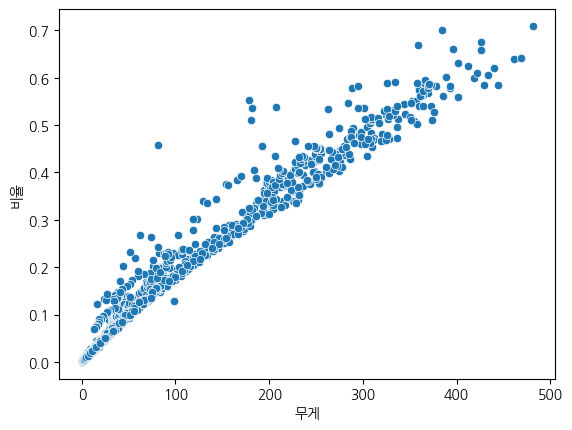

In [10]:
_ = sns.scatterplot(data=train_df, x="무게", y="비율")

In [11]:
image_outliers = ['CASE05_21','CASE05_22','CASE05_23', 'CASE07_07', 'CASE07_08', 'CASE16_03', 'CASE23_01', 'CASE23_02', 
'CASE23_03', 'CASE23_04', 'CASE23_05', 'CASE23_06', 'CASE23_07', 'CASE23_08', 'CASE23_09', 'CASE45_16', 'CASE45_17',
'CASE72_06',  'CASE73_10', 'CASE59_01','CASE59_02','CASE59_03','CASE59_04','CASE59_05','CASE59_06',
'CASE59_07','CASE59_08','CASE59_09','CASE59_10','CASE59_11','CASE59_12','CASE59_13','CASE59_14','CASE59_15','CASE59_16','CASE59_17','CASE59_18',
'CASE59_19','CASE59_20','CASE59_21','CASE59_22','CASE59_23','CASE59_24','CASE59_25','CASE59_26','CASE59_27','CASE59_28','CASE59_29','CASE59_30',
'CASE59_31','CASE59_32', 'CASE59_33']

train_df_image = train_df[~train_df["이미지"].isin(image_outliers)]
train_imgs_removed = [x for x in processed_train_imgs if x.split(".")[1].split("\\")[1] not in image_outliers]

### CNN

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available():
    print("GPU")
else:
    print("CPU")

GPU


이전에는 토치 GPU 구동 확인을 했었는데 왜 CPU로 잡히는지 모르겠음...

In [27]:
CFG = {
    "IMG_SIZE" : 128,
    "EPOCHS" : 80,
    "LEARNIING_RATE" : 1e-3,
    "BATCH_SIZE" : 32,
    "SEED" : 42
}

In [14]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG["SEED"])

In [22]:
train_len = int(len(train_imgs_removed)*0.8)
weight = train_df_image['무게'].round(3).tolist()

train_img_path = train_imgs_removed[:train_len]
train_label = weight[:train_len]

val_img_path = train_imgs_removed[train_len:]
val_label = weight[train_len:]

In [23]:
len(train_img_path), len(train_label), len(val_img_path), len(val_label)

(1232, 1232, 308, 308)

In [24]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)
        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else: return image
    def __len__(self):
        return len(self.img_path_list)

In [25]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    ])

In [30]:
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_img_path, val_label, train_mode=True, transforms=test_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [31]:
class CNNRegressor(torch.nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.regressor = nn.Linear(3136, 1)
    def forward(self, x):
        # (Batch, 3, 128, 128) -> (Batch, 64, 7, 7)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.flatten(x, start_dim=1)
        out = self.regressor(x)
        return out

def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    # Loss Func.
    criterion = nn.L1Loss().to(device)
    best_mae = 9999
    for epoch in range(1, CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            optimizer.zero_grad()
            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            # backpropagation
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        if scheduler is not None:
            scheduler.step()
        
        # Evaluation
        val_mae = validation(model, val_loader, criterion, device)
        print(f"Epoch [{epoch}] Train MAE: [{np.mean(train_loss):.5f}] Val MAE: [{val_mae:.5f}]\n")
        if best_mae > val_mae:
            best_mae = val_mae
            torch.save(model.state_dict(), "./best_model.pth")
            print("Model Saved.")

def validation(model, val_loader, criterion, device):
    model.eval() # Evaluation
    val_loss = []
    with torch.no_grad():
        for img, label in tqdm(iter(val_loader)):
            img, label = img.float().to(device), label.float().to(device)

            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            
            val_loss.append(loss.item())

    val_mae_loss = np.mean(val_loss)
    return val_mae_loss

#### Train and Validation

In [32]:
CNNmodel = CNNRegressor().to(device)

optimizer = torch.optim.SGD(params=CNNmodel.parameters(), lr=CFG["LEARNIING_RATE"])
scheduler = None

train(CNNmodel, optimizer, train_loader, val_loader, scheduler, device)

100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Epoch [1] Train MAE: [77.63346] Val MAE: [85.81707]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


Epoch [2] Train MAE: [77.04038] Val MAE: [81.62168]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Epoch [3] Train MAE: [70.39875] Val MAE: [75.61562]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


Epoch [4] Train MAE: [69.72363] Val MAE: [74.73799]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Epoch [5] Train MAE: [70.05392] Val MAE: [74.79267]



100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


Epoch [6] Train MAE: [69.90136] Val MAE: [76.04561]



100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


Epoch [7] Train MAE: [69.71255] Val MAE: [75.43308]



100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


Epoch [8] Train MAE: [69.38562] Val MAE: [75.18105]



100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


Epoch [9] Train MAE: [69.90535] Val MAE: [74.39388]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


Epoch [10] Train MAE: [69.33968] Val MAE: [73.41925]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch [11] Train MAE: [67.84758] Val MAE: [68.62755]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Epoch [12] Train MAE: [62.85574] Val MAE: [52.29267]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


Epoch [13] Train MAE: [58.79524] Val MAE: [61.37452]



100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch [14] Train MAE: [60.61190] Val MAE: [52.15246]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


Epoch [15] Train MAE: [54.52741] Val MAE: [79.40776]



100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


Epoch [16] Train MAE: [68.72975] Val MAE: [75.12443]



100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Epoch [17] Train MAE: [67.55206] Val MAE: [73.49052]



100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


Epoch [18] Train MAE: [58.38963] Val MAE: [35.46205]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Epoch [19] Train MAE: [56.75773] Val MAE: [70.95214]



100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch [20] Train MAE: [64.77877] Val MAE: [77.17768]



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch [21] Train MAE: [60.42913] Val MAE: [61.17237]



100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Epoch [22] Train MAE: [49.31255] Val MAE: [37.50734]



100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


Epoch [23] Train MAE: [51.67941] Val MAE: [38.37481]



100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Epoch [24] Train MAE: [22.42244] Val MAE: [15.68796]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


Epoch [25] Train MAE: [15.03096] Val MAE: [12.56386]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch [26] Train MAE: [13.38407] Val MAE: [38.01975]



100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Epoch [27] Train MAE: [12.46089] Val MAE: [15.13308]



100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


Epoch [28] Train MAE: [11.29771] Val MAE: [28.99264]



100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Epoch [29] Train MAE: [11.76292] Val MAE: [10.83459]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Epoch [30] Train MAE: [10.96475] Val MAE: [15.38150]



100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


Epoch [31] Train MAE: [10.37270] Val MAE: [11.18581]



100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Epoch [32] Train MAE: [10.67674] Val MAE: [19.84827]



100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


Epoch [33] Train MAE: [11.32597] Val MAE: [10.44233]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch [34] Train MAE: [9.67072] Val MAE: [17.65076]



100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Epoch [35] Train MAE: [9.78531] Val MAE: [10.68248]



100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


Epoch [36] Train MAE: [10.31705] Val MAE: [25.70298]



100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


Epoch [37] Train MAE: [9.74802] Val MAE: [14.44091]



100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Epoch [38] Train MAE: [9.28697] Val MAE: [15.07053]



100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


Epoch [39] Train MAE: [8.81085] Val MAE: [30.85335]



100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


Epoch [40] Train MAE: [8.90793] Val MAE: [10.30914]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


Epoch [41] Train MAE: [9.70648] Val MAE: [10.27281]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch [42] Train MAE: [8.82670] Val MAE: [10.88987]



100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


Epoch [43] Train MAE: [9.31853] Val MAE: [10.52927]



100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


Epoch [44] Train MAE: [8.76835] Val MAE: [10.46500]



100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Epoch [45] Train MAE: [9.15852] Val MAE: [11.91012]



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch [46] Train MAE: [8.27570] Val MAE: [10.05436]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch [47] Train MAE: [8.55672] Val MAE: [10.02788]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


Epoch [48] Train MAE: [8.64751] Val MAE: [12.18125]



100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


Epoch [49] Train MAE: [8.76342] Val MAE: [9.92334]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


Epoch [50] Train MAE: [9.13333] Val MAE: [15.35262]



100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


Epoch [51] Train MAE: [8.63092] Val MAE: [17.07517]



100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch [52] Train MAE: [7.40235] Val MAE: [14.62287]



100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


Epoch [53] Train MAE: [7.80194] Val MAE: [10.75808]



100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Epoch [54] Train MAE: [8.42614] Val MAE: [12.41213]



100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


Epoch [55] Train MAE: [7.37052] Val MAE: [12.54824]



100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


Epoch [56] Train MAE: [7.44951] Val MAE: [24.13488]



100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


Epoch [57] Train MAE: [7.98919] Val MAE: [12.61462]



100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch [58] Train MAE: [7.79633] Val MAE: [18.45711]



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch [59] Train MAE: [6.98566] Val MAE: [9.69445]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


Epoch [60] Train MAE: [8.18486] Val MAE: [22.61176]



100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch [61] Train MAE: [7.42978] Val MAE: [21.61352]



100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


Epoch [62] Train MAE: [7.72194] Val MAE: [10.98111]



100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch [63] Train MAE: [7.69448] Val MAE: [13.85906]



100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


Epoch [64] Train MAE: [7.34426] Val MAE: [24.91404]



100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch [65] Train MAE: [7.03759] Val MAE: [19.94041]



100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


Epoch [66] Train MAE: [7.37537] Val MAE: [15.40997]



100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


Epoch [67] Train MAE: [7.64036] Val MAE: [16.59800]



100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


Epoch [68] Train MAE: [6.69214] Val MAE: [9.45757]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


Epoch [69] Train MAE: [7.01585] Val MAE: [12.97643]



100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Epoch [70] Train MAE: [7.18000] Val MAE: [27.03320]



100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


Epoch [71] Train MAE: [7.51271] Val MAE: [14.63263]



100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch [72] Train MAE: [6.68019] Val MAE: [11.16940]



100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch [73] Train MAE: [7.34100] Val MAE: [11.72314]



100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Epoch [74] Train MAE: [7.19626] Val MAE: [17.94428]



100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Epoch [75] Train MAE: [7.14724] Val MAE: [8.73243]

Model Saved.


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Epoch [76] Train MAE: [6.89424] Val MAE: [16.48698]



100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


Epoch [77] Train MAE: [7.80199] Val MAE: [9.66979]



100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Epoch [78] Train MAE: [6.91679] Val MAE: [8.84517]



100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Epoch [79] Train MAE: [7.02968] Val MAE: [11.80710]



100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

Epoch [80] Train MAE: [7.41040] Val MAE: [13.52668]



#### Predict

In [33]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)
            pred_logit = model(img)
            pred_logit = pred_logit.squeeze(1).detach().cpu()
            model_pred.extend(pred_logit.tolist())
    return model_pred

In [34]:
test_dataset = CustomDataset(processed_test_imgs, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

checkpoint = torch.load('./best_model.pth')
CNNmodel = CNNRegressor().to(device)
CNNmodel.load_state_dict(checkpoint)

# Inference
preds = predict(CNNmodel, test_loader, device)

100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


In [64]:
submission = pd.read_csv('./open/sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('./CNNsubmit.csv', index=False)

### Meatadata EDA
- 각 환경 변수 시각화
- 이상치 판단
- CASE01, CASE02 경우 EC 관측치, 외부 온도 값이 다른 케이스에 비해 다르므로 제외
- 음수값이 나오는 최근 분무량 제외
- CO2 관측치가 0인 케이스는 누락 데이터로 판단 -> 제외

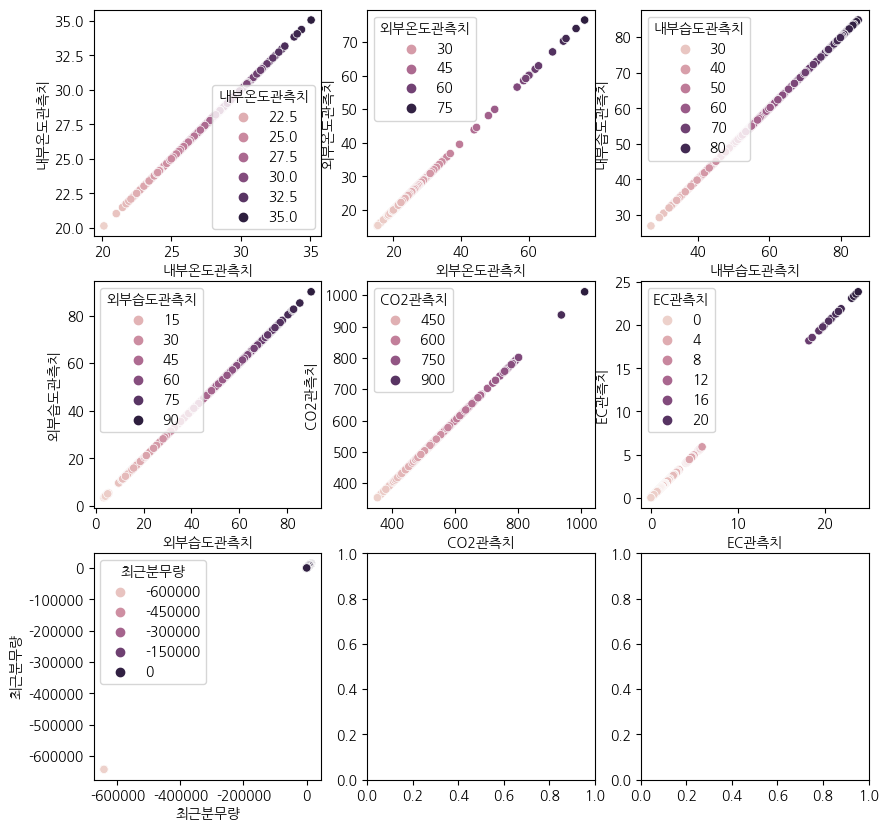

In [50]:
firstfeats = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치','최근분무량']
secondfeats = ['냉방온도', '냉방부하','난방온도', '난방부하', '비율']
thirdfeats = ['화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

idx = 0
for row in range(3):
    for col in range(3):
        try:
            sns.scatterplot(x=train_df[firstfeats[idx]], y=train_df[firstfeats[idx]], ax=ax[row][col], hue=train_df[firstfeats[idx]])
            idx += 1
        except:
            pass

In [49]:
meta_outliers = ['CASE01_01','CASE01_02','CASE01_03','CASE01_04','CASE01_05','CASE01_06','CASE01_07',
'CASE01_08','CASE01_09','CASE02_01','CASE02_02','CASE02_03','CASE02_04','CASE02_05','CASE02_06','CASE02_07',
'CASE02_08','CASE02_09','CASE02_10','CASE02_11']

train_df_meta = train_df_image[~train_df_image['이미지'].isin(meta_outliers)]

train_df_meta = train_df_meta[train_df_meta['CO2관측치'] > 0]
train_df_meta = train_df_meta[train_df_meta['최근분무량'] >= 0]

- 특성간 상관관계가 높은 변수는 제거 (LED 동작 강도)
- 총추정광량은 백색추정광량, 적생광추정과량, 청색광추정광량 합이므로 총추정광향 변수 제거

In [53]:
corr = train_df_meta.corr()
corr.style.background_gradient(cmap='coolwarm')

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,비율
내부온도관측치,1.000000,0.914757,-0.592165,-0.348850,0.093577,0.233087,-0.260451,-0.021698,-0.366392,-0.412055,0.028192,0.608341,0.300661,-0.250316,-0.341991,-0.089971,-0.366396,-0.412047,-0.096137,-0.122599
외부온도관측치,0.914757,1.000000,-0.495556,-0.277455,-0.025140,0.104751,-0.218209,-0.096884,-0.394604,-0.520013,-0.017607,0.596009,0.229053,-0.270891,-0.439107,-0.151600,-0.394598,-0.519996,-0.005515,-0.029887
내부습도관측치,-0.592165,-0.495556,1.000000,0.752177,-0.037328,-0.517403,0.201364,-0.091622,0.276760,0.189064,-0.040844,-0.185409,-0.344317,0.194068,0.135976,-0.031516,0.276777,0.189070,0.225323,0.270407
외부습도관측치,-0.348850,-0.277455,0.752177,1.000000,-0.114504,-0.500501,-0.023921,-0.219330,0.181613,-0.062676,0.002730,-0.031856,-0.250606,0.225217,-0.102444,-0.178893,0.181610,-0.062680,0.117638,0.141438
CO2관측치,0.093577,-0.025140,-0.037328,-0.114504,1.000000,0.112437,-0.099955,0.141059,-0.019642,0.077924,-0.163204,0.201229,-0.116181,-0.109370,0.140163,0.153977,-0.019634,0.077936,0.024076,0.009779
EC관측치,0.233087,0.104751,-0.517403,-0.500501,0.112437,1.000000,-0.195874,0.251206,0.131422,0.357484,0.087924,-0.026613,0.256154,-0.057690,0.349921,0.225883,0.131423,0.357497,-0.153996,-0.171411
최근분무량,-0.260451,-0.218209,0.201364,-0.023921,-0.099955,-0.195874,1.000000,0.274187,-0.038251,0.245956,-0.136779,-0.082902,-0.118560,-0.130924,0.283771,0.265799,-0.038245,0.245923,-0.284305,-0.276562
화이트 LED동작강도,-0.021698,-0.096884,-0.091622,-0.219330,0.141059,0.251206,0.274187,1.000000,-0.347680,0.354309,-0.359168,0.023614,-0.003158,-0.383132,0.745572,0.950771,-0.347626,0.354327,-0.343482,-0.360687
레드 LED동작강도,-0.366392,-0.394604,0.276760,0.181613,-0.019642,0.131422,-0.038251,-0.347680,1.000000,0.496119,0.299690,-0.131863,-0.263039,0.597813,0.269544,-0.311848,1.000000,0.496131,0.246122,0.268795
블루 LED동작강도,-0.412055,-0.520013,0.189064,-0.062676,0.077924,0.357484,0.245956,0.354309,0.496119,1.000000,-0.103579,-0.269058,-0.053375,-0.005121,0.814108,0.360140,0.496143,1.000000,0.048466,0.060023


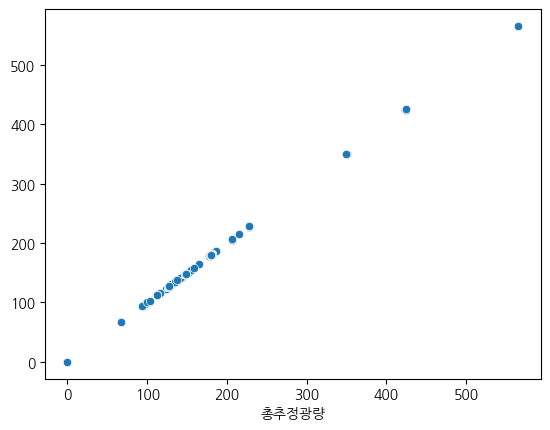

In [55]:
sns.scatterplot(train_df_meta, x=train_df_meta["총추정광량"], y=train_df_meta["백색광추정광량"]+train_df_meta["적색광추정광량"]+train_df_meta["청색광추정광량"]);

### CatBoost

In [56]:
features = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
         '최근분무량', '냉방온도', '냉방부하',
         '난방온도', '난방부하', '백색광추정광량', '적색광추정광량', '청색광추정광량', '비율']

train_col = train_df_meta[features]

test_col = test_df[features]

train_target = train_df_meta["무게"]

train_x, val_x, train_y, val_y = train_test_split(train_col, train_target, test_size=0.2, random_state=32)

Learning rate set to 0.012542
0:	learn: 81.6377352	test: 85.8903420	best: 85.8903420 (0)	total: 147ms	remaining: 24m 30s
50:	learn: 47.6997804	test: 51.2987982	best: 51.2987982 (50)	total: 233ms	remaining: 45.5s
100:	learn: 28.0058685	test: 31.0580658	best: 31.0580658 (100)	total: 326ms	remaining: 32s
150:	learn: 17.0894826	test: 19.3769332	best: 19.3769332 (150)	total: 414ms	remaining: 27s
200:	learn: 10.8896436	test: 12.4684166	best: 12.4684166 (200)	total: 526ms	remaining: 25.6s
250:	learn: 7.6249227	test: 8.8072031	best: 8.8072031 (250)	total: 626ms	remaining: 24.3s
300:	learn: 5.8797504	test: 6.8367847	best: 6.8367847 (300)	total: 716ms	remaining: 23.1s
350:	learn: 4.8953149	test: 5.8192176	best: 5.8192176 (350)	total: 811ms	remaining: 22.3s
400:	learn: 4.3015578	test: 5.2305001	best: 5.2305001 (400)	total: 904ms	remaining: 21.6s
450:	learn: 3.9049092	test: 4.8237123	best: 4.8237123 (450)	total: 999ms	remaining: 21.1s
500:	learn: 3.6361614	test: 4.5592975	best: 4.5592975 (500)	tot

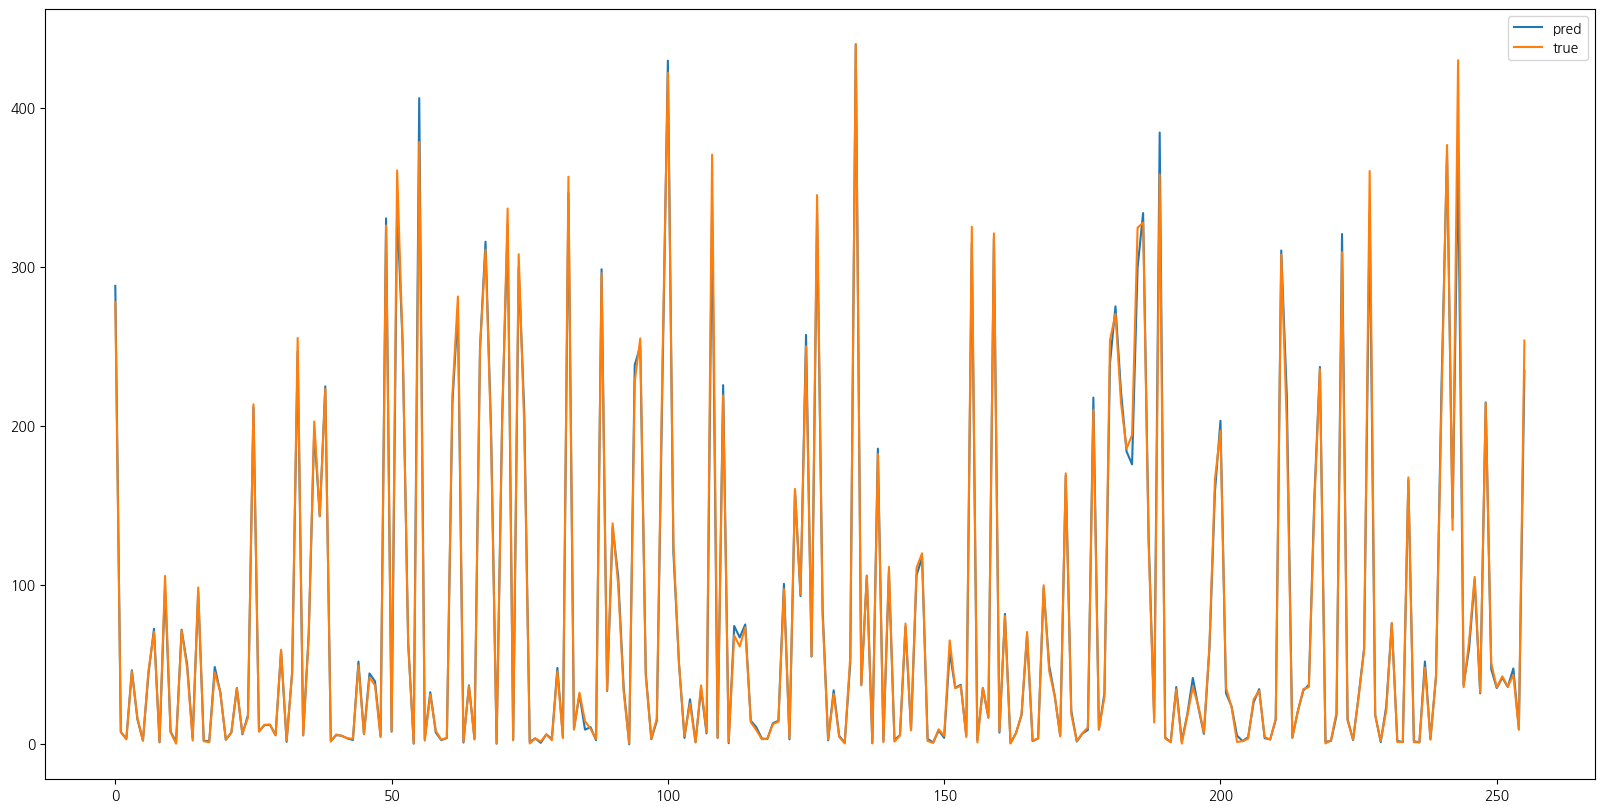

In [57]:
CATmodel = CatBoostRegressor(verbose=50, n_estimators=10000, eval_metric="MAE", early_stopping_rounds=50)
CATmodel.fit(train_x, train_y, eval_set=[(val_x, val_y)], use_best_model=True)

val_pred = CATmodel.predict(val_x)
plt.figure(figsize=(20,10))
plt.plot(np.array(val_pred),label = "pred")
plt.plot(np.array(val_y),label = "true")
plt.legend()
plt.show()

train_score = CATmodel.score(train_x, train_y)
val_score = CATmodel.score(val_x, val_y)

In [58]:
CATresult = CATmodel.predict(test_col)

submission = pd.read_csv('./open/sample_submission.csv')
submission['leaf_weight'] = CATresult
submission.to_csv('./CATsubmit.csv', index=False)

### ANN
- sklearn으로 메타 데이터 스케일 조정

In [59]:
def scale_datasets(x_train, x_test):
    # Z - Score
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
        standard_scaler.fit_transform(x_train),
        columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
        standard_scaler.transform(x_test),
        columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled

train_scaled, test_scaled = scale_datasets(train_col, test_col)

train_x_scale, val_x_scale, train_y_scale, val_y_scale = train_test_split(train_scaled, train_target, test_size=0.2, random_state=32)

In [60]:
tf.random.set_seed(42)

def build_model_using_sequential():
    model = Sequential([
      Dense(100, kernel_initializer='normal', activation='relu'),
      Dense(50, kernel_initializer='normal', activation='relu'),
      Dense(25, kernel_initializer='normal', activation='relu'),
      Dense(1, kernel_initializer='normal', activation='linear')
    ])
    return model

ANNmodel = build_model_using_sequential()

# Loss Func.
mae = MeanAbsoluteError()
ANNmodel.compile(
    loss=mae, 
    optimizer=Adam(learning_rate=0.001), 
    metrics=[mae]
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=50,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# train the model
history = ANNmodel.fit(
    train_x_scale, 
    train_y_scale, 
    epochs=1000, 
    batch_size=32,
    validation_data=(val_x_scale, val_y_scale),
    callbacks=[early_stopping_monitor],
    verbose= 2
)

Epoch 1/1000
32/32 - 1s - loss: 79.6819 - mean_absolute_error: 79.6508 - val_loss: 80.7002 - val_mean_absolute_error: 80.7002 - 1s/epoch - 34ms/step
Epoch 2/1000
32/32 - 0s - loss: 78.0658 - mean_absolute_error: 78.0423 - val_loss: 77.3219 - val_mean_absolute_error: 77.3219 - 129ms/epoch - 4ms/step
Epoch 3/1000
32/32 - 0s - loss: 71.0327 - mean_absolute_error: 71.0571 - val_loss: 67.2468 - val_mean_absolute_error: 67.2468 - 133ms/epoch - 4ms/step
Epoch 4/1000
32/32 - 0s - loss: 57.0773 - mean_absolute_error: 57.0375 - val_loss: 50.8774 - val_mean_absolute_error: 50.8774 - 157ms/epoch - 5ms/step
Epoch 5/1000
32/32 - 0s - loss: 41.6919 - mean_absolute_error: 41.6892 - val_loss: 36.2440 - val_mean_absolute_error: 36.2440 - 133ms/epoch - 4ms/step
Epoch 6/1000
32/32 - 0s - loss: 29.6422 - mean_absolute_error: 29.6190 - val_loss: 23.5988 - val_mean_absolute_error: 23.5988 - 129ms/epoch - 4ms/step
Epoch 7/1000
32/32 - 0s - loss: 18.2704 - mean_absolute_error: 18.2559 - val_loss: 12.5317 - val

8/8 [==============================] - 0s 2ms/step


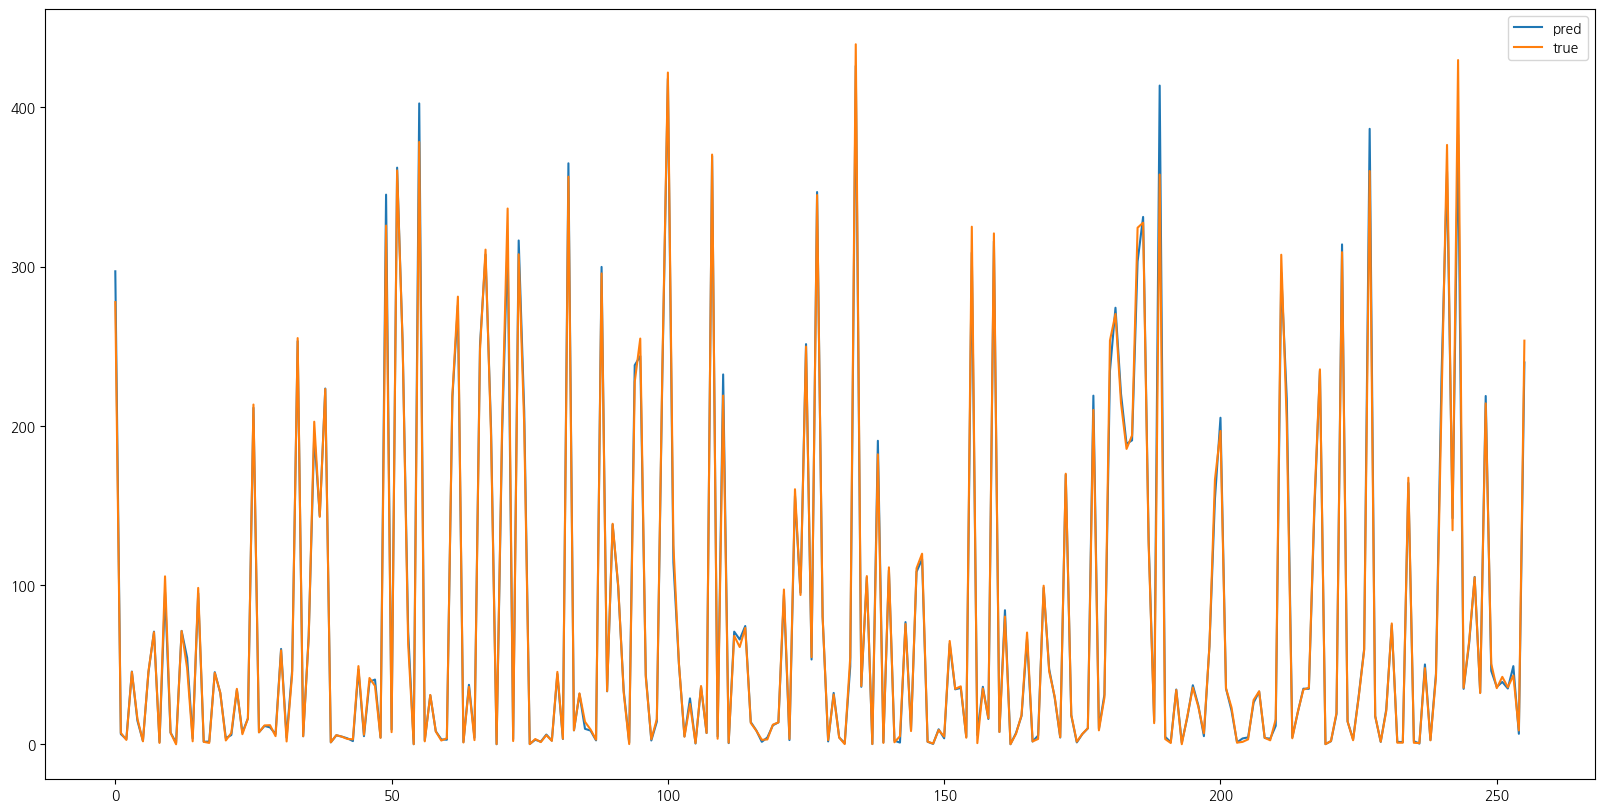

In [61]:
val_pred = ANNmodel.predict(val_x_scale)
plt.figure(figsize=(20,10))
plt.plot(np.array(val_pred),label = "pred")
plt.plot(np.array(val_y_scale),label = "true")
plt.legend()
plt.show()

In [62]:
ANNresult = ANNmodel.predict(test_scaled)

submission = pd.read_csv('./open/sample_submission.csv')
submission['leaf_weight'] = ANNresult
submission.to_csv('./ANNsubmit.csv', index=False)

15/15 [==============================] - 0s 2ms/step


### Ensemble

In [65]:
CNN = pd.read_csv('./CNNsubmit.csv')
CAT = pd.read_csv('./CATsubmit.csv')
ANN = pd.read_csv('./ANNsubmit.csv')

submission_final = pd.read_csv('./open/sample_submission.csv')
submission_final['leaf_weight'] = (CNN['leaf_weight'] * 0.65 + CAT['leaf_weight'] * 0.25 + ANN['leaf_weight'] * 0.1)
submission_final.to_csv('ENSEMBLEsubmit.csv', index=False)

### 마무리
- 이미지 데이터와 메타 데이터가 함께 있는 경우 어떻게 전처리를 하고 사용하는지 의아했는데, 해당 필사를 통해 일부 궁금증을 해소할 수 있었음